(ex_system_rev)=

# The expression system, revisited

## Long sums and products

heyoka.py internally represents sums and products as multivariate functions. E.g., the expression $x+y+z$, is represented as a single function with 3 arguments $x$, $y$ and $z$, rather than two nested binary additions, i.e., $\left( x + y \right) + z$. While such a representation has the advantage of being well-suited for the implementation of several automatic simplifications, it results in quadratic complexity when iteratively building long sums and products via repeated additions and multiplications. For instance, consider the following code for the construction of the expression $x_0 + x_1 + \ldots + x_9$:

In [1]:
import heyoka as hy

long_sum = hy.expression(0.)

# BAD: quadratic complexity.
for i in range(10):
    long_sum += hy.expression(f"x_{i}")
    
long_sum

(x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9)

While this code is correct, every time the addition operator is invoked in the loop a new copy of the arguments in ``long_sum`` is created, resulting in overall quadratic complexity. This behaviour can be avoided by preparing a list of terms for the summation and then inovking the ``heyoka.sum()`` function:

In [2]:
terms = [hy.expression(f"x_{i}") for i in range(10)]
# GOOD: linear complexity.
long_sum = hy.sum(terms)

long_sum

(x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9)

Similarly for products:

In [3]:
terms = [hy.expression(f"x_{i}") for i in range(10)]
# GOOD: linear complexity.
long_prod = hy.prod(terms)

long_prod

(x_0 * x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8 * x_9)

## Automatic simplifications

heyoka.py's expression system implements several simplifications/normalisations which are automatically applied when an expression is created. Constants, for instance, are automatically folded:

In [4]:
hy.expression(1.) + hy.expression(2.)

3.0000000000000000

In [5]:
hy.cos(hy.expression(.5))

0.87758256189037276

Nested sums and products are automatically flattened:

In [6]:
x, y, z = hy.make_vars("x", "y", "z")

((1. + x) + y) + z

(1.0000000000000000 + x + y + z)

In [7]:
((2. * x) * y) * z

(2.0000000000000000 * x * y * z)

Terms in sums and products are sorted according to a canonical order:

In [8]:
y + x + 1.

(1.0000000000000000 + x + y)

Sums of products with numerical coefficients are automatically gathered:

In [9]:
2.*x + 3.*x

(5.0000000000000000 * x)

Similarly, products of exponentiations with numerical exponents are also gathered:

In [10]:
x**2. * x**3.

x**5.0000000000000000

The product of a numerical coefficient and a sum is automatically expanded:

In [11]:
2. * (x + y + z)

((2.0000000000000000 * x) + (2.0000000000000000 * y) + (2.0000000000000000 * z))

Nested exponentiations are flattened:

In [12]:
(x**2.)**3.

x**6.0000000000000000

Exponentiations of products with integral exponents are expanded:

In [13]:
(x*y)**3.

(x**3.0000000000000000 * y**3.0000000000000000)

These simplifcations are almost always automatically applied. One notable exception is the substitution function ``subs()``, which, by default, does not apply any automatic simplification:

In [14]:
hy.subs(x + y, {x : y})

(y + y)

As you can see, $y+y$ has not been simplified to $2y$. We can explicitly request the application of the automatic simplifications rules either by invoking the ``normalise()`` function:

In [15]:
hy.normalise(hy.subs(x + y, {x : y}))

(2.0000000000000000 * y)

Or, equivalently, by passing the ``normalise=True`` flag when invoking ``subs()``:

In [16]:
hy.subs(x + y, {x : y}, normalise=True)

(2.0000000000000000 * y)

## Preventing automatic simplifications

It can sometimes be desirable to prevent the simplifications automatically applied by the expression system. Consider, for instance, the vector-valued function

$$
\boldsymbol{f}\left(x, y, z\right) = \left(x + y + 1, x + y + z\right).
$$

We can implement in heyoka.py a [compiled function](<./compiled_functions.ipynb>) for the fast evaluation of $\boldsymbol{f}\left(x, y, z\right)$:

In [17]:
f_cf = hy.make_cfunc([x+y+1., x+y+z])

Let us take a look at the decomposition of $\boldsymbol{f}\left(x, y, z\right)$:

In [18]:
f_cf.decomposition

[x, y, z, (1.0000000000000000 + u_0 + u_1), (u_0 + u_1 + u_2), u_3, u_4]

As usual, the first three elements are the inputs of the function $\left(x, y, z\right)$, while the last two elements represent the outputs of the function (i.e., $u_3$ indicates that the first output is the expression at index 3 in the decomposition, while $u_4$ indicates that the second output is the expression at index 4 in the decomposition). The two elements in the middle of the decomposition are the components of $\boldsymbol{f}\left(x, y, z\right)$, which happen to be already elementary subexpressions (and which are thus not decomposed any further).

A visual inspection of $\boldsymbol{f}\left(x, y, z\right)$ immediately shows how the expression $x+y$ appears in both components. heyoka.py's compiled functions are usually able to identify and remove repeated subexpressions from the decomposition in order to avoid repeated (and redundant) evaluations of the same subexpressions. However, in this specific case $x+y$ does not show up in the decomposition as a standalone subexpression, because it is part of the ternary sums $x + y + 1$ and $x + y + z$. One may be tempted to use brackets to isolate $x+y$ from the other terms of the sums, but this approach will not work due to the expression system automatically flattening nested sums (and essentially removing the extra brackets):

In [19]:
(x + y) + 1.

(1.0000000000000000 + x + y)

For these situations, heyoka.py provides a function called ``fix()`` that acts as a barrier to automatic simplifications. Let us try it:

In [20]:
hy.fix(x + y) + 1.

(1.0000000000000000 + {(x + y)})

The curly brackets indicate that $x+y$ has been fixed. Because $x+y$ is now wrapped in a ``fix()`` function, we are not dealing any more with a nested summation, and no automatic flattening is applied by heyoka.py.

Let us try to compile a new version of $\boldsymbol{f}\left(x, y, z\right)$ in which $x+y$ is fixed in both components:

In [21]:
f_cf_fix = hy.make_cfunc([hy.fix(x+y)+1., hy.fix(x+y)+z])

And let us take a look at the decomposition:

In [22]:
f_cf_fix.decomposition

[x, y, z, (u_0 + u_1), (1.0000000000000000 + u_3), (u_2 + u_3), u_4, u_5]

We can now see how in the decomposition $x + y$ is computed only once (as $u_0 + u_1$), and the result is then re-used in the computation of both outputs. As a result, the total number of floating-point operations necessary to evaluate $\boldsymbol{f}\left(x, y, z\right)$ has been reduced from 4 (in ``f_cf``) to 3 (in ``f_cf_fix``).

As another example, consider the scalar function

$$
g\left(x, y, z\right) = 2\left(x+y+z\right).
$$

If we implement this function in heyoka.py, the product is immediately expanded due to the automatic simplification rules:

In [23]:
2.0 * (x + y + z)

((2.0000000000000000 * x) + (2.0000000000000000 * y) + (2.0000000000000000 * z))

Let us compile $g\left(x, y, z\right)$ and let us take a look at the decomposition:

In [24]:
g_cf = hy.make_cfunc([2.0 * (x + y + z)])
g_cf.decomposition

[x,
 y,
 z,
 (2.0000000000000000 * u_0),
 (2.0000000000000000 * u_1),
 (2.0000000000000000 * u_2),
 (u_3 + u_4 + u_5),
 u_6]

Clearly, this is suboptimal as 3 multiplications are needed for the evaluation instead of only 1. Let us try to ``fix()`` $\left( x + y + z \right)$ in order to prevent the automatic expansion:

In [25]:
g_cf_fix = hy.make_cfunc([2.0 * hy.fix(x + y + z)])
g_cf_fix.decomposition

[x, y, z, (u_0 + u_1 + u_2), (2.0000000000000000 * u_3), u_4]

Indeed, the expansion has been prevented and as a result the total number of operations necessary to evaluate $g\left(x, y, z\right)$ has been reduced from 5 to 3.

In addition to ``fix()``, the closely-related ``fix_nn()`` function is also available. ``fix_nn()`` will fix an expression only if it is not a number:

In [26]:
# fix() prevents constant folding.
hy.cos(hy.fix(hy.expression(.5)))

cos({0.50000000000000000})

In [27]:
# fix_nn() allows constant folding.
hy.cos(hy.fix_nn(hy.expression(.5)))

0.87758256189037276

The ``unfix()`` function can be used to remove all instances of ``fix()`` within an expression:

In [28]:
ex = 2.0 * hy.fix(x + y + z)

# Unfix ex.
ex_unfix = hy.unfix(ex)
ex_unfix

(2.0000000000000000 * (x + y + z))

Note how ``unfix()`` only removes the instances of ``fix()`` within the expression tree, but it does not re-apply the automatic simplifications. Automatic simplifications can be applied via the ``normalise()`` function:

In [29]:
hy.normalise(ex_unfix)

((2.0000000000000000 * x) + (2.0000000000000000 * y) + (2.0000000000000000 * z))

## Computing derivatives

heyoka.py provides two ways of computing the derivatives of an expression. The first one is the ``diff()`` function:

In [30]:
hy.diff(x + hy.cos(y*z), z)

-(y * sin((y * z)))

The ``diff()`` function implements symbolic differentiation of an expression with respect to a variable (or a parameter) via a straightforward application of the chain rule. Repeated applications of ``diff()`` can be used to compute higher-order derivatives.

The other way of computing derivatives in heyoka.py is the ``diff_tensors()`` function. ``diff_tensors()`` computes the full tensors of derivatives up to an arbitrary order. Let us see a simple example:

In [31]:
dt = hy.diff_tensors([x + hy.cos(y*z), hy.exp(x-z) + hy.log(y)], diff_order=1)

Here we are asking for the derivatives of a 2-component vector-valued function with respect to all variables up to order 1. The value returned by ``diff_tensors()`` is an object of type ``dtens``. Let us explore it a bit:

In [32]:
dt

Highest diff order: 1
Number of outputs : 2
Diff arguments    : [x, y, z]

The screen output shows some general information: the derivative order, the number of outputs and the differentiation arguments. ``dtens`` objects have a length corresponding to the total number of derivatives stored within the object:

In [33]:
len(dt)

8

Here we have 8 derivatives in total: 2 order-0 derivatives (i.e., the original components of the function, which are returned in the ``dtens`` object) and 6 order-1 derivatives (3 for each component of the function).

``dtens`` is a dictionary-like ordered container mapping vectors of integral indices to derivatives. It is possible to iterate over the indices vectors, so that, e.g., we can build an ordered list of all the indices vectors in ``dt``:

In [34]:
list(dt)

[[0, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 1, 0, 0],
 [1, 0, 1, 0],
 [1, 0, 0, 1]]

Each index vector begins with an index representing the function component. The remaining indices represent the derivative orders with respect to the variables. Thus, the index vector ``[1, 0, 1, 0]`` is used to indicate the first-order derivative of the second function component with respect to the second variable $y$.

Indices vector in a ``dtens`` object are sorted as follows:

- first, according to the total differentiation order in ascending order,
- then, according to the function component in ascending order,
- finally, in reverse lexicographic order with respect to the derivative orders for the differentiation arguments.

We can lookup specific derivatives via the square brackets operator. For instance, here is the first-order derivative of the second component with respect to $x$:

In [35]:
dt[1, 1, 0, 0]

exp((x - z))

We can check if a specific index vector appears in a ``dtens`` object via the ``in`` operator:

In [36]:
[3, 3, 3, 3] in dt

False

The ``get_derivatives()`` method can be used to fetch all derivatives for a specific total order. For instance, we can fetch the Jacobian from ``dt``:

In [37]:
dt.get_derivatives(diff_order=1)

[([0, 1, 0, 0], 1.0000000000000000),
 ([0, 0, 1, 0], (z * -sin((y * z)))),
 ([0, 0, 0, 1], (y * -sin((y * z)))),
 ([1, 1, 0, 0], exp((x - z))),
 ([1, 0, 1, 0], y**-1.0000000000000000),
 ([1, 0, 0, 1], -exp((x - z)))]

We can also ask for the derivatives of a specific component:

In [38]:
dt.get_derivatives(diff_order=1, component=0)

[([0, 1, 0, 0], 1.0000000000000000),
 ([0, 0, 1, 0], (z * -sin((y * z)))),
 ([0, 0, 0, 1], (y * -sin((y * z))))]

### diff() vs diff_tensors()

``diff()`` and ``diff_tensors()`` both compute symbolic derivatives, and thus produce mathematically-equivalent results. However, the symbolic structure of the expressions returned by ``diff()`` and ``diff_tensors()`` can differ in ways that have a profound impact on the runtime complexity of the numerical evaluation of the derivatives.

``diff()`` always applies the chain rule in [forward mode](https://en.wikipedia.org/wiki/Automatic_differentiation#Forward_accumulation), and it also always applies the automatic simplifications described earlier in this tutorial. It is somewhat analogue to a pen-and-paper calculation.

By contrast, ``diff_tensors()`` may choose, depending on the function being differentiated and on the differentiation order, to perform symbolic differentiation in [reverse mode](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation), rather than in forward mode. ``diff_tensors()`` also extensively uses ``fix()`` to disable most automatic simplifications with the goal of producing symbolic expressions that are as close as possible to verbatim transcriptions of the forward/reverse mode automatic differentiation (AD) algorithms.

In order to clarify, let us show a concrete example where the differences between ``diff()`` and ``diff_tensors()`` matter a great deal. Speelpenning's function

$$
f\left(x_1, x_2, \ldots, x_n \right) = x_1\cdot x_2 \cdot \ldots \cdot x_n
$$

has often been used to ([incorrectly](https://arxiv.org/abs/1904.02990)) argue that numerical reverse-mode AD is superior to symbolic differentiation. Let us try to compute the gradient of this function first using ``diff()`` and then using ``diff_tensors()``.

Let us begin with the definition of the function (we take $n=8$):

In [39]:
sym_vars = [hy.expression(f"x_{i}") for i in range(1, 9)]
sp_func = hy.prod(sym_vars)
sp_func

(x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8)

Now let us compute the gradient via ``diff()``:

In [40]:
grad_diff = [hy.diff(sp_func, v) for v in sym_vars]
grad_diff

[(x_2 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_7)]

We can see how in the components of the gradient there are multiple repeated subexpressions. It is however unclear how one would select and isolate these common subexpressions with the goal of avoiding redundant computations - in general, this is a combinatorially-hard symbolic optimisation problem.

If we construct a compiled function for the evaluation of ``grad_diff`` and examine its decomposition, we can confirm that the number of operations needed to evaluate ``grad_diff`` scales quadratically $\operatorname{O}\left(n^2\right)$ with the number of variables:

In [41]:
grad_diff_cf = hy.make_cfunc(grad_diff)
grad_diff_cf.decomposition[8:-8]

[(u_0 * u_1 * u_2 * u_3 * u_4 * u_5 * u_6),
 (u_1 * u_2 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_2 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_4 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_4 * u_5 * u_7)]

Now let us take a look at how ``diff_tensors()`` behaves instead:

In [42]:
grad_diff_tensors = [t[1] for t in hy.diff_tensors([sp_func], diff_order=1).get_derivatives(1)]
grad_diff_tensors

[(x_2 * (((x_5 * x_6) * (x_7 * x_8)) * (x_3 * x_4))),
 (x_1 * (((x_5 * x_6) * (x_7 * x_8)) * (x_3 * x_4))),
 (x_4 * (((x_5 * x_6) * (x_7 * x_8)) * (x_1 * x_2))),
 (x_3 * (((x_5 * x_6) * (x_7 * x_8)) * (x_1 * x_2))),
 (x_6 * ((x_7 * x_8) * ((x_1 * x_2) * (x_3 * x_4)))),
 (x_5 * ((x_7 * x_8) * ((x_1 * x_2) * (x_3 * x_4)))),
 (x_8 * ((x_5 * x_6) * ((x_1 * x_2) * (x_3 * x_4)))),
 (x_7 * ((x_5 * x_6) * ((x_1 * x_2) * (x_3 * x_4))))]

When computing the gradient of a multivariate scalar function, ``diff_tensors()`` automatically selects reverse-mode symbolic differentiation. We can see how the reverse-mode AD algorithm collects the terms in nested binary multiplications which occur multiple times in the gradient's components. As a consequence, when creating a compiled function for the evaluation of ``grad_diff_tensors``, the repeated subexpressions are recognised by heyoka.py and evaluated only once. Let us check:

In [43]:
grad_diff_tensors_cf = hy.make_cfunc(grad_diff_tensors)
grad_diff_tensors_cf.decomposition[8:-8]

[(u_0 * u_1),
 (u_2 * u_3),
 (u_4 * u_5),
 (u_6 * u_7),
 (u_8 * u_9),
 (u_10 * u_11),
 (u_11 * u_12),
 (u_10 * u_12),
 (u_13 * u_9),
 (u_13 * u_8),
 (u_5 * u_14),
 (u_4 * u_14),
 (u_7 * u_15),
 (u_6 * u_15),
 (u_1 * u_16),
 (u_0 * u_16),
 (u_3 * u_17),
 (u_2 * u_17)]

The total number of operations needed to evaluate the gradient has been reduced from 48 (via ``diff()``) to 18 (via ``diff_tensors()``). Indeed, we can show how the computational complexity of the evaluation of the gradient of Speelpenning's function via reverse-mode symbolic AD scales linearly $\operatorname{O}\left(n\right)$ with the number of variables:

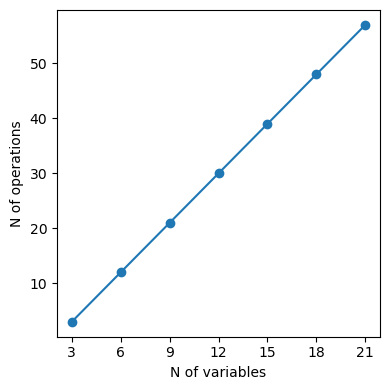

In [44]:
nops = []
nvars_list = [3, 6, 9, 12, 15, 18, 21]

for nvars in nvars_list:
    sym_vars = [hy.expression(f"x_{i}") for i in range(1, nvars+1)]
    sp_func = hy.prod(sym_vars)
    grad_diff_tensors = [t[1] for t in hy.diff_tensors([sp_func], diff_order=1).get_derivatives(1)]
    grad_diff_tensors_cf = hy.make_cfunc(grad_diff_tensors)
    nops.append(len(grad_diff_tensors_cf.decomposition) - 2*nvars)

%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize = (4, 4))

plt.plot(nvars_list, nops, 'o-')
plt.xticks(nvars_list)
plt.xlabel("N of variables")
plt.ylabel("N of operations")

plt.tight_layout();

### General guidelines

In conclusion, how should one choose whether to use ``diff()`` or ``diff_tensors()`` to compute symbolic derivatives in heyoka.py?

``diff()`` should be used when the goal is to produce human-readable symbolic expressions, and when one wants to take advantage of heyoka.py's symbolic simplification capabilities.

If, however, the goal is to optimise the performance of the numerical evaluation of derivatives, then one should use ``diff_tensors()``.